# Building a Language Model
***
# Table of Contents
1.  [Imports](#Imports)
2.  [Methodology](#Methodology)
3.  [Corpus](#Corpus)
4.  [Model](#Model)
5.  [Evaluation](#Evaluation)
6.  [References](#References)

# UPDATE CODE IN THESE CELLS
# Imports

8 libraries are needed for this project:
* numpy - Word filtering
* lxml - To read broken xml files
* re - To split lines with regex
* tqdm.notebook - tqdm progress bars, but for ipynb files
* os - File traversal
* collections - for defaultdict
* LanguageModel - Contains the Corpus and Model class (same code), split for cleanliness
* random - For sampling
* sklearn

In [1]:
from lxml import etree
import re
from tqdm.notebook import tqdm
import os
import pandas as pd
import numpy as np
from collections import defaultdict
from LanguageModel import Corpus, Model
import random
from sklearn.model_selection import train_test_split
import operator
from collections import OrderedDict
import matplotlib.pyplot as plt

# Methodology
# Mhux bilfors methodology essacc anka naqa graphics fuq id data for the gucci marks

# Corpus

## The Reasoning Behind the Code
*keywords*: Corpus, NGram, Model

### Initialization

The corpus object mainly represents the pre-processed data of a given *corpus* as well as its processed form as NGrams
and probability models. It can also be seen as a paragraph of sentences.

On initialization the *corpus* data is read and stored as a list of sentences, where each sentence is a list of words,
where each word is a string.
>Previously I had a Word object that would retain the **4 columns**, however this was causing
a lot of clutter and would interfere with the generation process, so I dropped it for the simpler string.

A vanilla unigram and model are also created at this time.

The option is given to the user to create a corpus object from an existing list of lists of strings (another corpus).

### Usage

The corpus object is intended to be used as a non static object for one set of xml files. This would give a user the
ability to have multiple corpus objects that load in different xml files.

Once created the ```Model()```,  ```NGram()``` and ```LinearInterpolation()``` functions can be used to efficiently give
the desired output. As for traversing the corpus list itself, this can be done by accessing ```self``` as ```__len___()```,
```__iter()__``` and ```__getitem()__``` are written for this purpose.

All 3 attributes; ```_corpus```,```_ngrams```,```_models``` are intended to be private

## Code Explanation

### _ReadCorpus

This function checks the root location of where all xml files are contained and if it encounters no issue accessing it,
it will read the contents of the files within it and return them in the form of a list.

In [2]:
def _ReadCorpus(root='Corpus/'):
    if not os.access(root, os.R_OK):
        print('Check root!!')

    xml_data = []

    for file in tqdm(os.listdir(root), desc='Reading Files'):
        xml_data.append(open(os.path.join(root, file), 'r', encoding='utf8').read())
    return xml_data

### _ParseAsXML

The parser being used is initialised and the xml data from the files is read into ```xml_data```. Each file is then parsed
and appended to ```roots```. Each file is split in a number of texts, so ```roots``` is a list of these parsed texts.

In [3]:
def _ParseAsXML(root='Corpus/'):
    parser = etree.XMLParser(recover=True)
    roots = []
    xml_data = Corpus._ReadCorpus(root)
    for xml in tqdm(xml_data, desc='Parsing XML'):
        roots.append(etree.fromstring(xml, parser=parser))
    return roots

### _CorpusAsListOfSentences

This function is the last step in creating a pre-processed corpus.

```sentences``` a python list is initialised.

It is important to understand the Maltese dataset xml structure to properly understand this step.

Each text has a number of paragraphs, and each paragraph has a number of sentences, each of these containing a number of
words. Every word has 4 values; **4 columns**.

The 3 nested loops show the movement from sentence to sentence. Each sentence is filtered using regex. This filter splits
the sentence into a list of words (including the extra values). Now each word has its extra values removed. ***I decided
against removing punctuation and stop words or do any other pre processing since I found it unnecessary. When a
sentence is processed, I also wanted to see whether the model could accurately predict punctuation.*** The start and end
tags are added in the appropriate place.


#### Previous Version
Before settling on this I attempted to have the *corpus* as a Pandas dataframe. This would have been useful if I
continued on developing a tensor oriented approach to the problem. However, since I scrapped that idea since a pd dataframe was
causing too much clutter as all the sentences would have to be the same length.

In [4]:
def CorpusAsListOfSentences(root='Corpus/'):
    roots = Corpus._ParseAsXML(root)
    sentences = []
    for root in tqdm(roots, desc='XML File'):
        for i, p in tqdm(enumerate(root), desc='Paragraph'):
            for k, s in enumerate(p):
                unfiltered_sentence = re.split(r'\n', s.text.lstrip('\n'))
                sentence = []
                for unfiltered_word in unfiltered_sentence:
                    if unfiltered_word is not '':
                        filtered_word = unfiltered_word.split('\t')
                        sentence.append(filtered_word[0])

                if sentence is not []:
                    sentence.insert(0, '<s>')
                    sentences.append(sentence)
                    sentence.append('</s>')
    return sentences

### Counts

The Counts function counts the ```n``` sized sequences in ```self``` (the corpus).

This is done by looping over each sentence, gathering a tuple of each ```n``` sized sequence and counting its
occurrences.

The counts are kept in a dictionary of this form:

```Python
counts = {sequence: count}
```

Where sequence is a tuple of size ```n``` and count is an integer containing the number of counts.

In [5]:
def Counts(self, n):
    counts = defaultdict(lambda: 0)
    for s in tqdm(self, desc='Counting x counts'):
        for i in range(len(s) + 1):
            if i < n:
                continue
            count = []
            for x in range(n,0,-1):
                count.append(s[i - x])
            count = tuple(count)

            counts[count] += 1

    return counts

### NGram

*keywords*: Vanilla, Laplace, UNK

The NGram function returns a dictionary of the NGram counts for a ```model``` of ```n```grams.

```model``` and ```n``` are used as flags for the ngram object.

Some error handling is done. Then an ```identifier``` is built to check whether an existing ngram exists with the flags given.
If one exists then the function returns it.

If there is no NGram object that satisfies the given flags a new ngram is created.


If the ```model``` is specified to be *laplace* or *vanilla* the counts of ```n``` sized sequences in the ```corpus```
are counted using ```Counts()```.

* Then if the ```model``` is specified to be *laplace*, each count is added by 1.

Else, if the ```model``` is specified to be *unk*, a temp corpus is created using the *vanilla* unigram counts. If a word
is written less than 3 times it is omitted from the new corpus. The ```n``` counts of this new corpus are counted.

In any case a ```counts``` variable is created in the form as described in the **Counts()** section.

The ```model``` is added to the ```counts``` variable which makes up the final NGram dictionary. Using the previous ```identifier```
this new NGram is added to the ```corpus._ngrams``` dictionary as well as returned.

In [6]:
def NGram(self, n=2, model='vanilla'):
    if n < 1:
        raise Exception('Unigrams and up are supported, otherwise no.')

    if model != 'vanilla' and \
            model != 'laplace' and \
            model != 'unk':
        raise Exception('Only "vanilla"/"laplace"/"unk" models are supported.')

    identifier = tuple([n, model])
    if identifier in self._ngrams:
        if self._ngrams[identifier]['model'] == model:
            return self._ngrams[identifier]

    if model == 'laplace' or model == 'vanilla':
        counts = self.Counts(n=n)

        if model == 'laplace':
            for x in counts:
                counts[x] += 1

    else:
        _count = self.Counts(n=1)
        tc = []
        for s in self:
            ts = []
            for w in s:
                if _count[tuple([w])] < 3:
                    ts.append('UNK')
                else:
                    ts.append(w)
            tc.append(ts)

        temp = Corpus(corpus=tc)
        counts = temp.Counts(n=n)

    result = {
        'count': counts,
        'model': model
    }

    self._ngrams[identifier] = result
    return self._ngrams[identifier]

### GetCount

The GetCount function returns the count of a given n sized sequence.

Some error handling is done. Afterwards the count is returned.

This function is intended to be used instead of accessing the count values directly in the dictionary like so:

```self.NGram(n, model)['count'][sequence]```

to avoid missing key errors as well as to return 1 for the laplace models.

In [7]:
def GetCount(self, sequence: tuple, model='vanilla'):
    n = len(sequence)
    if n < 1:
        raise Exception('Unigrams and up are supported, otherwise no.')

    if model != 'vanilla' and \
            model != 'laplace' and \
            model != 'unk':
        raise Exception('Only "vanilla"/"laplace"/"unk" models are supported.')

    _ngram = self.NGram(n, model)['count']

    if sequence in _ngram:
        return _ngram[sequence]
    else:
        if model == 'laplace':
            return 1
        else:
            return 0

### Model

The Model function returns a Model object that has ```model``` and ```n``` as its flags.

Some error handling is done. Then an ```identifier``` is built to check whether an existing Model exists with the flags given.
If one exists then the function returns it.

If there is no Model object that satisfies the given flags a new Model is created, added to the ```corpus._models```
dictionary as well as returned.

Even though both ```model``` and ```n``` are kept in a Model object, the same system that is used for NGram retrieval is
used here to maintain code form and readability.

In [8]:
def _Model(self, n=2, model='vanilla'):
    if n < 1:
        raise Exception('Unigrams and up are supported, otherwise no.')

    if model != 'vanilla' and \
            model != 'laplace' and \
            model != 'unk':
        raise Exception('Only "vanilla"/"laplace"/"unk" models are supported.')

    identifier = tuple([n, model])
    if identifier in self._models:
        if  self._models[identifier].model == model:
            return self._models[identifier]

    self._models[identifier] = Model(corpus=self,n=n,model=model)
    return self._models[identifier]

### GetProbability

GetProbability returns the probability of ```input``` in an ```n```gram ```model```.

Some error handling is included.

```input``` has to be either a string, a list of strings or a list of lists of strings.

A temporary corpus is created out of ```input```.

The ```n```grams of ```input``` are counted and a ```model``` model is created from self (not the ```input``` corpus).

Then the input probability is calculated by multiplying the probability of each ngram that appears in ```input```.

Since **NGrams()** removes the order of re appearing ngrams are counted, the ngram probability powered to its count in
```input```.

#### Note

Probabilities for the ngrams are not calculated at this stage.

In [9]:
def GetProbability(self, input, n, model='vanilla'):
    if n < 1:
        raise Exception('Unigrams and up are supported, otherwise no.')

    if model != 'vanilla' and \
            model != 'laplace' and \
            model != 'unk':
        raise Exception('Only "vanilla"/"laplace"/"unk" models are supported.')

    if type(input) is str:
        tc = Corpus([[input]])
    else:
        paragraph = False
        for elem in input:
            if isinstance(elem, list):
                paragraph = True
            if paragraph and not isinstance(elem, list):
                raise Exception('Input must be of the forms:\nstr\n[str, str, str]\n[[str, str, str], ...,  [str, '
                                'str, str]].')

        if paragraph:
            tc = Corpus(input)
        else:
            tc = Corpus([input])

    _model = self.Model(n=n, model=model)
    _ngram = tc.NGram(n=n, model=model)

    input_probability = 1
    exists = False
    for _n in _ngram['count']:
        exists = True
        input_probability *= _model.GetProbabilityMath(_n[-1], _n[:n-1]) ** tc.GetCount(_n, model=model)

    if not exists:
        input_probability = 0

    return input_probability

### TrigramLinearInterpolation

This function returns the Trigram Linear Interpolation for a given input.

Some error handling is included.

```input``` has to be either a string, a list of strings or a list of lists of strings.

A temporary corpus is created out of ```input```.

The lambdas are defined.

Then the Trigram Linear Interpolation is calculated by adding the probabilities of each part of every trigram in ```input```.
Each probability is also multiplied to its respective lambda.

In [10]:
def TrigramLinearInterpolation(self, input, model='vanilla'):
    if model != 'vanilla' and \
            model != 'laplace' and \
            model != 'unk':
        raise Exception('Only "vanilla"/"laplace"/"unk" models are supported.')

    paragraph = False
    for elem in input:
        if isinstance(elem, list):
            paragraph = True
        if paragraph and not isinstance(elem, list):
            raise Exception('Input must be of the forms:\n[str, str, str]\n[[str, str, str], ...,  [str, str, '
                            'str]].')

    if paragraph:
        tc = Corpus(input)
    else:
        tc = Corpus([input])

    l1 = 0.1
    l2 = 0.3
    l3 = 0.6

    _ngram = tc.NGram(n=3, model=model)

    output = 1
    exists = False
    for _n in _ngram['count']:
        exists = True
        output *= l3 * self.GetProbability(input=[_n[2], _n[0], _n[1]], n=3, model=model) + \
                  l2 * self.GetProbability(input=[_n[2], _n[1]], n=2, model=model) + \
                  l1 * self.GetProbability(input=_n[2], n=1, model=model)

    if not exists:
        output = 0

    return output

# Model

## The Reasoning Behind the Code
*keywords*: Model, Perplexity, Probability

### Initialization

A Model requires a ```Corpus``` object, ```n``` and a ```model``` specifier.

V is defined as 0, if ```model``` is laplace, then it is changed to the length of the set of words.

The ngram counts of the model type is gathered from corpus. If ```model``` is laplace, the vanilla counts will be gathered
here.

N is defined as the total number of words in ```corpus```.

Then probability calculation is split into two parts; when n is 1 and when it is not 1.

When n is one, the probability is defined as:

* The count of each ngram + 1(if model is laplace) divided by N + V.

Otherwise it is defined as:

* The count of each ngram + 1(if model is laplace) divided by the count of each (n-1)gram + V.

In [11]:
def __init__(self, corpus, n=2, model='vanilla'):
    V = 0
    cmodel = model
    if model == 'laplace':
        cmodel = 'vanilla'
        V = len(corpus.NGram(n=1)['count'])

    counts = corpus.NGram(n, model=cmodel)['count']

    probabilities = {}
    self.N = len([w for s in corpus for w in s])

    if n is not 1:
        previous = corpus.NGram(n - 1, model=cmodel)['count']
        for x in counts:
            probabilities[x] = {
                'probability': (counts[x] + int(model == 'laplace')) / (previous[x[:n - 1]] + V)}
    else:
        for x in counts:
            probabilities[x] = {'probability': (counts[x] + int(model == 'laplace')) / (self.N + V)}
    self.probabilities = probabilities
    self.model = model

### Usage

The Model object is written for cleaner code and more readability. Originally it was a python dictionary that functioned
like corpus NGrams, however accessing its attributes became messy. In its object form I was able to separate Model specific
functionality like Perplexity calculation and getting Probability from Corpus.

## Code Explanation

### GetProbabilityMath

GetProbabilityMath returns the probability ```forX```, ```givenY```. The function is written in this way to stay similar
to how Probability notation is written mathematically.

I.e. P(Sam | I am)

If the sequence ```givenY``` + ```forX``` exists, its probability is returned.
Else it will return 0.
(For laplace any given input will return a number that is not 0)

In [12]:
def GetProbabilityMath(self, forX, givenY):
    sequence = givenY + (forX,)

    if sequence in self.probabilities:
        return self.probabilities[sequence]['probability']
    else:
        return 0

### Perplexity

Perplexity returns the perplexity of the Model.

This is done by multiplying all the probabilities in the model, then powering that to -1/N. N being the number of words
in a model.

In [13]:
def Perplexity(self):
    prob = 1
    for p in self.probabilities:
        prob *= self.probabilities[p]['probability']

    return prob ** -(1 / self.N)

# Evaluation
Check laplace counts

In [14]:
dataset = Corpus.CorpusAsListOfSentences(root='Maltese/', verbose=True)

Reading Files:   0%|          | 0/28 [00:00<?, ?it/s]

Parsing XML:   0%|          | 0/28 [00:00<?, ?it/s]

Building Sentences:   0%|          | 0/28 [00:00<?, ?it/s]

Paragraph: 0it [00:00, ?it/s]

Paragraph: 0it [00:00, ?it/s]

Paragraph: 0it [00:00, ?it/s]

Paragraph: 0it [00:00, ?it/s]

Paragraph: 0it [00:00, ?it/s]

Paragraph: 0it [00:00, ?it/s]

Paragraph: 0it [00:00, ?it/s]

Paragraph: 0it [00:00, ?it/s]

Paragraph: 0it [00:00, ?it/s]

Paragraph: 0it [00:00, ?it/s]

Paragraph: 0it [00:00, ?it/s]

Paragraph: 0it [00:00, ?it/s]

Paragraph: 0it [00:00, ?it/s]

Paragraph: 0it [00:00, ?it/s]

Paragraph: 0it [00:00, ?it/s]

Paragraph: 0it [00:00, ?it/s]

Paragraph: 0it [00:00, ?it/s]

Paragraph: 0it [00:00, ?it/s]

Paragraph: 0it [00:00, ?it/s]

Paragraph: 0it [00:00, ?it/s]

Paragraph: 0it [00:00, ?it/s]

Paragraph: 0it [00:00, ?it/s]

Paragraph: 0it [00:00, ?it/s]

Paragraph: 0it [00:00, ?it/s]

Paragraph: 0it [00:00, ?it/s]

Paragraph: 0it [00:00, ?it/s]

Paragraph: 0it [00:00, ?it/s]

Paragraph: 0it [00:00, ?it/s]

In [15]:
train, test = train_test_split(dataset, shuffle=True, test_size=0.2)

In [16]:
train_corpus = Corpus(train,verbose=True)

Counting x counts:   0%|          | 0/3234 [00:00<?, ?it/s]

In [17]:
test_corpus = Corpus(test,verbose=True)

Counting x counts:   0%|          | 0/809 [00:00<?, ?it/s]

In [18]:
params =    {
                "n": [1,2,3],
                "model": ["vanilla", "laplace", "unk"]
            }

In [19]:
for n in tqdm(params["n"]):
    for model in params["model"]:
        train_corpus.NGram(n=n, model=model)
        train_corpus.Model(n=n, model=model)
        test_corpus.NGram(n=n, model=model)
        test_corpus.Model(n=n, model=model)

  0%|          | 0/3 [00:00<?, ?it/s]

In [20]:
unigram = OrderedDict()
bigram = OrderedDict()
trigram = OrderedDict()
interpolation = OrderedDict()
# make these sorted
for n in tqdm(params["n"]):
    for model in params["model"]:
        testgrams = test_corpus.NGram(n=n,model=model)['count']
        probabilities = {}
        for gram in testgrams:
            probabilities[gram] = train_corpus.GetProbability(input=gram,n=n,model=model)

        sorted_tuples = sorted(probabilities.items(), key=operator.itemgetter(1))

        title = ''
        if n == 1:
            unigram[model] = {}
            for k, v in sorted_tuples:
                unigram[model][k] = v
            # unigram[model] = probabilities
        elif n == 2:
            bigram[model] = {}
            for k, v in sorted_tuples:
                bigram[model][k] = v
            # bigram[model] = probabilities
        else:
            trigram[model] = {}
            for k, v in sorted_tuples:
                trigram[model][k] = v
            # trigram[model] = probabilities

        if n == 3:
            interpolations = {}

            for gram in testgrams:
                interpolations[gram] = train_corpus.LinearInterpolation(trigram=gram, model=model)
            sorted_tuples = sorted(interpolations.items(), key=operator.itemgetter(1))
            interpolation[model] = {}
            for k, v in sorted_tuples:
                interpolation[model][k] = v
            #interpolation[model] = interpolations


  0%|          | 0/3 [00:00<?, ?it/s]

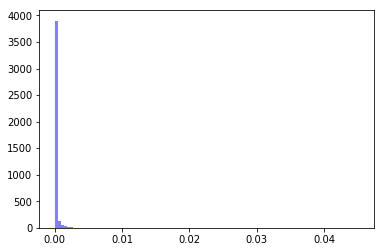

In [22]:
n, bins, patches = plt.hist(unigram['vanilla'].values(), 100, facecolor='blue', alpha=0.5)
plt.show()

test = Model(probabilities=bigram['vanilla'], n=2, model='vanilla')

print(test.Perplexity())
print(test_corpus.Model().Perplexity())

# Print 5 tables as shown in pdf

heading =   "\t\t|Unigram\t\t|\tBigram\t\t\t|\tTrigram\t\t\t|\tLinear  Interpolation"
line =  "************************************************************************************************************"\
        "******************"

data_template =     "Vanilla\t|\t{}:{:.1f}%\t|\t{}:{:.1f}%\t|\t{}:{:.1f}%\t|\t{}:{:.1f}%\n" \
                    "Laplace\t|\t{}:{:.1f}%\t|\t{}:{:.1f}%\t|\t{}:{:.1f}%\t|\t{}:{:.1f}%\n" \
                    "UNK\t|\t{}:{:.1f}%\t|\t{}:{:.1f}%\t|\t{}:{:.1f}%\t|\t{}:{:.1f}%"


for i in range(min(len(unigram["unk"]), 5)):
    i = -i
    print(heading)
    print(line)
    print(data_template.format(
            " ".join([f'{x[:5]:<5}' for x in list(unigram["vanilla"].keys())[i]]), (unigram["vanilla"][list(unigram["vanilla"].keys())[i]]) * 100,
            " ".join([f'{x[:5]:<5}' for x in list(bigram["vanilla"].keys())[i]]), (bigram["vanilla"][list(bigram["vanilla"].keys())[i]]) * 100,
            " ".join([f'{x[:5]:<5}' for x in list(trigram["vanilla"].keys())[i]]), (trigram["vanilla"][list(trigram["vanilla"].keys())[i]]) * 100,
            " ".join([f'{x[:5]:<5}' for x in list(interpolation["vanilla"].keys())[i]]), (interpolation["vanilla"][list(interpolation["vanilla"].keys())[i]]) * 100,
            " ".join([f'{x[:5]:<5}' for x in list(unigram["laplace"].keys())[i]]), (unigram["laplace"][list(unigram["laplace"].keys())[i]]) * 100,
            " ".join([f'{x[:5]:<5}' for x in list(bigram["laplace"].keys())[i]]), (bigram["laplace"][list(bigram["laplace"].keys())[i]]) * 100,
            " ".join([f'{x[:5]:<5}' for x in list(trigram["laplace"].keys())[i]]), (trigram["laplace"][list(trigram["laplace"].keys())[i]]) * 100,
            " ".join([f'{x[:5]:<5}' for x in list(interpolation["laplace"].keys())[i]]), (interpolation["laplace"][list(interpolation["laplace"].keys())[i]]) * 100,
            " ".join([f'{x[:5]:<5}' for x in list(unigram["unk"].keys())[i]]), (unigram["unk"][list(unigram["unk"].keys())[i]]) * 100,
            " ".join([f'{x[:5]:<5}' for x in list(bigram["unk"].keys())[i]]), (bigram["unk"][list(bigram["unk"].keys())[i]]) * 100,
            " ".join([f'{x[:5]:<5}' for x in list(trigram["unk"].keys())[i]]), (trigram["unk"][list(trigram["unk"].keys())[i]]) * 100,
            " ".join([f'{x[:5]:<5}' for x in list(interpolation["unk"].keys())[i]]), (interpolation["unk"][list(interpolation["unk"].keys())[i]]) * 100))
    print(line)

In [ ]:
# do generations here

In [ ]:
#print(Corpus(test,verbose=True).Model(n=2).Perplexity())

# Check documentation update it
# References


1. G. Pibiri and R. Venturini, "Handling Massive N -Gram Datasets Efficiently", ACM Transactions on Information Systems, vol. 37, no. 2, pp. 1-41, 2019. Available: 10.1145/3302913 [Accessed 8 April 2021].
https://towardsdatascience.com/perplexity-in-language-models-87a196019a94

cite
https://mlrs.research.um.edu.mt/index.php?page=downloads